# Multi objective optimization post-processing analysis

In [1]:
using Revise
using FUSE
using JLD2
using Plots;
using Metaheuristics;
gr();

## Process data

### Choose run directory

In [2]:
result_path = "nominal/opt_betaN_cost__Solovev_Kr_flattop24_HTS0.1_qpol2.75_A3.5_Zeff2.0/"

"nominal/opt_betaN_cost__Solovev_Kr_flattop24_HTS0.1_qpol2.75_A3.5_Zeff2.0/"

### Read and/or write cache

In [3]:
if false
        
    cache_path = result_path

    IMAS.update_ExtractFunctionsLibrary!(); # to pick up any ongoing development to extract function library
    outputs = FUSE.extract(nothing; filter_invalid=:cols, cache=joinpath(cache_path, "combined.csv"), read_cache=true, write_cache=false);
end

### Error analysis

60672
58092


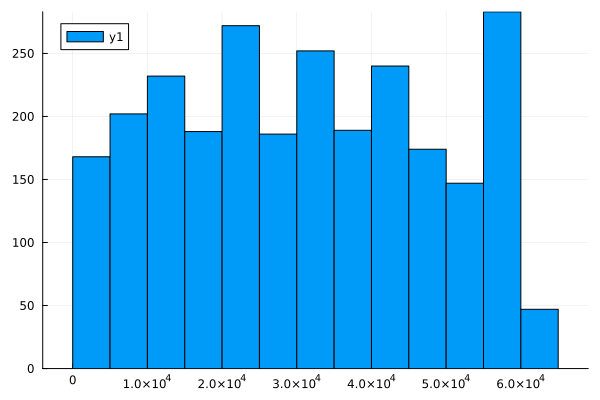

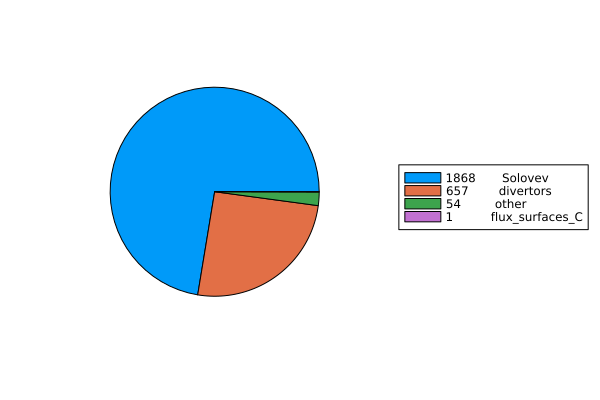

DomainError with -7.659465509401997e-6:
sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).
Stacktrace:
  [1] throw_complex_domainerror(f::Symbol, x::Float64)
    @ Base.Math ./math.jl:33
  [2] sqrt
    @ ./math.jl:591 [inlined]
  [3] _broadcast_getindex_evalf
    @ ./broadcast.jl:670 [inlined]
  [4] _broadcast_getindex
    @ ./broadcast.jl:643 [inlined]
  [5] _getindex
    @ ./broadcast.jl:666 [inlined]
  [6] _broadcast_getindex
    @ ./broadcast.jl:642 [inlined]
  [7] _getindex
    @ ./broadcast.jl:667 [inlined]
  [8] _getindex
    @ ./broadcast.jl:666 [inlined]
  [9] _broadcast_getindex
    @ ./broadcast.jl:642 [inlined]
 [10] _getindex
    @ ./broadcast.jl:666 [inlined]
 [11] _broadcast_getindex
    @ ./broadcast.jl:642 [inlined]
 [12] getindex
    @ ./broadcast.jl:597 [inlined]
 [13] macro expansion
    @ ./broadcast.jl:961 [inlined]
 [14] macro expansion
    @ ./simdloop.jl:77 [inlined]
 [15] copyto!
    @ ./broadcast.jl:960 [inlined]
 

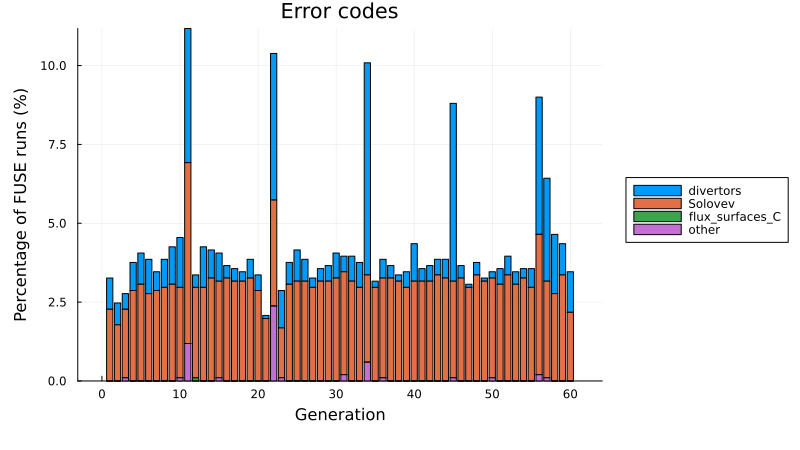

In [19]:
using StatsPlots

cache_path = joinpath(result_path, "opt_runs/")
all_dirs = filter(isdir, sort(readdir(cache_path; join=true)))
println(length(all_dirs))

dirs = sort(filter(x -> !isfile(joinpath(x, "error.txt")) && isfile(joinpath(x, "dd.json")), all_dirs))
println(length(dirs))

errors = FUSE.categorize_errors(all_dirs; do_plot=true, show_first_line=false)
err = errors[:Solovev][end]
println(read(err * "/error.txt",String))

x = Dict()
h = Dict()
ngen = 60
nbins = Int(floor(ngen))
bins = StepRange(1,floor(length(all_dirs) ÷ nbins),length(all_dirs))

for key in keys(errors)
    x[key] = indexin(errors[key],sort(all_dirs))
    h[key] = []
    for (b0,b1) in zip(bins[1:end-1],bins[2:end])
        n = length(findall((x[key] .< b1) .* (x[key] .> b0)))
        h[key] = [h[key]; n]
    end
end

data = [h[key] for key in keys(errors)]
nticks = nbins
xticks = (0:1:nbins, [string(x) for x in LinRange(0,ngen,nticks)])

g = groupedbar(convert(Matrix{Int},reduce(hcat, data)) ./ (length(all_dirs)/nbins) * 100, 
    bar_position=:stack,
    label=String.(reduce(hcat,keys(errors))),
    xlabel="Generation",
    ylabel="Percentage of FUSE runs (%)",
    title ="Error codes",
    legend=:outerright,
    #xticks=xticks,
    left_margin = 5Plots.mm,
    bottom_margin = 8Plots.mm,
    )

display(plot(g,size=(800,450)))


## Visualize Optimzation results

### Load optimization results file

In [5]:
con = []

try
    @load joinpath(result_path, "result.jld2") result
    for c in result.convergence
        con = [con; c]
    end
catch
    display("Could not find result.jld2")
end

try
    @load joinpath(result_path, "result2.jld2") result2
    for c in result2.convergence
        con = [con; c]
    end
catch
    display("Could not find result2.jld2")
end

try
    @load joinpath(result_path, "result3.jld2") result3
    for c in result3.convergence
        con = [con; c]
    end
catch
    display("Could not find result3.jld2")
end

┌ Warning: Opening file with JLD2.MmapIO failed, falling back to IOStream
└ @ JLD2 ~/.julia/packages/JLD2/cHcDY/src/JLD2.jl:287


"Could not find result3.jld2"

### Organize results into dict arrays

In [6]:
fnames = [ "cost (\$B)", "βn (-)"]
xnames = ["B0 (T)", "R0 (m)", "P0 (MPa)", "Ip (MA)", "fGW (-)", "fGWped (-)", "Paux (MW)"]
xfac = [1, 1, 1e6, 1e6, 1, 1, 1e6]
gnames = ["Pnet (% >)", "Sn (% <)", "accessEC (% <)", "fLH (% >)", "qpol (% <)", "Hds03 (% <)", "TF_j_margin (% >)", "OH_j_margin (% >)", "TF_stress_margin (% >)", "OH_stress_margin (% >)"]
gfac = [200, 1.5, 1.0, 1.0, 2.75, 1.0, 1.5, 1.5, 1.0, 1.0]
gunit = ["MW", "-", "-", "-", "GW/m^2", "-", "-", "-", "-" ,"-"]

db = Dict()
pf = []

# loop over number of generations
for i in 1:1:length(con)
    A = pareto_front(con[i])
    B = con[i].population
    
    # get input values, objective values, and constraint values
    pop_x = reduce(hcat, [j.x for j in B])'
    pop_f = reduce(hcat, [j.f for j in B])'
    pop_g = reduce(hcat, [j.g for j in B])'
    
    # populate objective values 
    for (j,fname) in enumerate(fnames)
        try
            db[fname] = hcat(db[fname], pop_f[:,j])
        catch
            db[fname] = pop_f[:,j]
        end
    end
    
    # populate input values with scale factor
    for (j,xname) in enumerate(xnames)
        try
            db[xname] = hcat(db[xname], pop_x[:,j]./xfac[j])
        catch
            db[xname] = pop_x[:,j].*xfac[j]
        end
    end
    
    # populate constraint values with conversion factor
    for (j,gname) in enumerate(gnames)
        if occursin("<", gname)
            tmp = @. gfac[j]*(1+pop_g[:,j])
        elseif occursin(">", gname)
            tmp = @. gfac[j]*(1-pop_g[:,j])
        end
        gname = split(gname," ")[1]*" ("*gunit[j]*")"
        try
            db[gname] = hcat(db[gname], tmp)
        catch
            db[gname] = tmp
        end
    end
    
    # find indices of Pareto-optimal solutions
    #index = zeros(Int,length(B))
    pfi = [findfirst(isequal(a), db[fnames[1]][:,i]) for a in A[:,1]]
    #index[pfi] .= 1
    pf = [pf; [pfi]]

end


In [7]:
pf

120-element Vector{Any}:
 [81]
 [28]
 [149]
 [124, 162]
 [59, 177, 241]
 [25, 89, 129, 216, 221]
 [10, 48, 70, 123, 126]
 [7, 29, 41, 83, 85, 206]
 [5, 16, 53, 144, 213, 254]
 [4, 89, 135, 167, 192, 225]
 [3, 130, 151, 175, 249, 252]
 [3, 112, 126, 147, 206, 209]
 [3, 96, 106, 124, 175, 178]
 ⋮
 [69, 116, 127, 134, 136, 151, 174, 204, 207, 217, 220, 226, 235]
 [66, 113, 123, 130, 132, 147, 169, 198, 201, 211, 214, 220, 229, 252]
 [64, 111, 121, 127, 129, 144, 166, 195, 198, 208, 211, 217, 226, 248, 256]
 [62, 108, 118, 124, 126, 141, 163, 191, 194, 204, 207, 213, 222, 244, 251, 254]
 [62, 107, 117, 123, 125, 140, 161, 189, 192, 202, 205, 211, 220, 242, 249, 252]
 [61, 105, 115, 121, 123, 159, 186, 189, 199, 202, 208, 217, 238, 245, 248, 256]
 [60, 101, 111, 117, 119, 155, 182, 185, 195, 198, 204, 212, 233, 240, 243, 251]
 [58, 98, 108, 114, 116, 151, 178, 181, 191, 194, 200, 208, 229, 236, 239, 256]
 [58, 97, 107, 113, 115, 150, 177, 180, 190, 193, 199, 207, 228, 235, 238, 255]
 [58, 9

### Plot f, x, g evolution

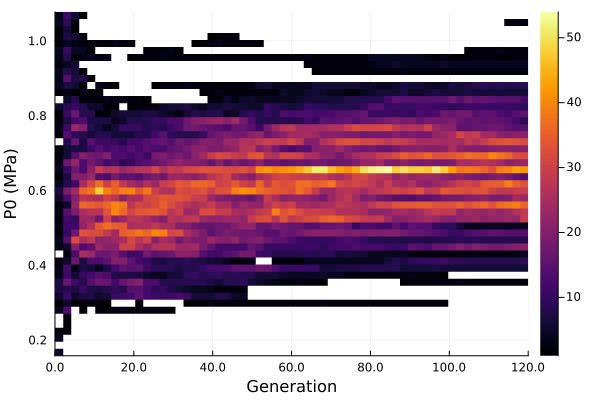

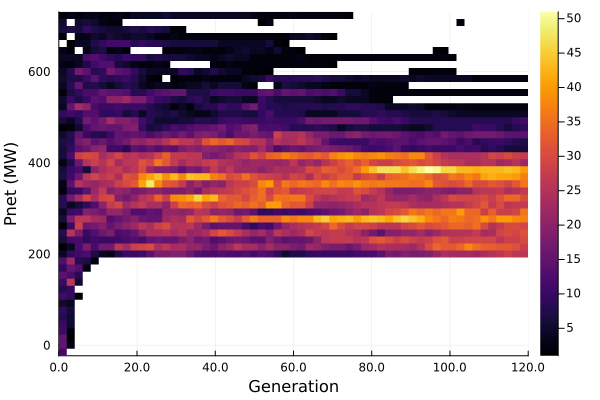

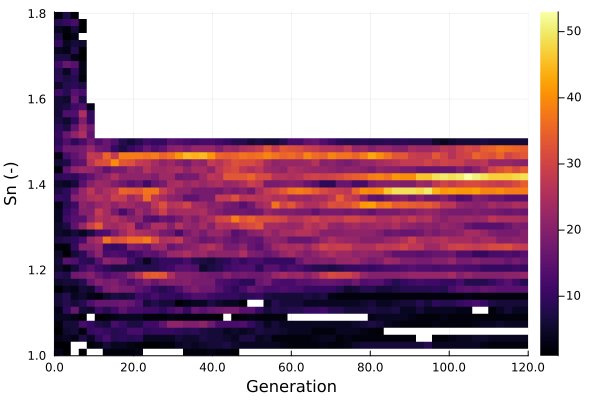

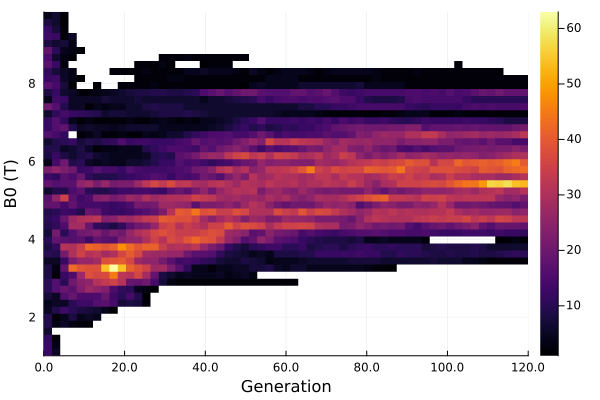

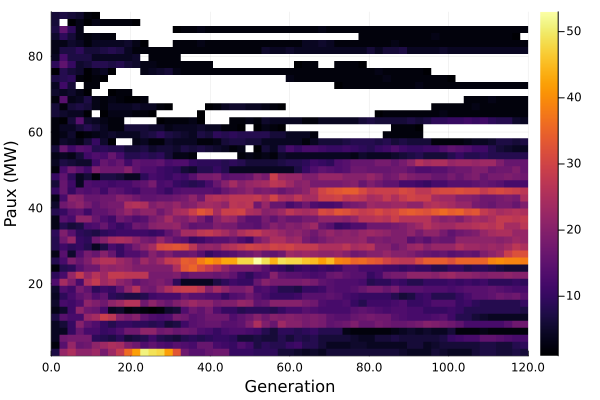

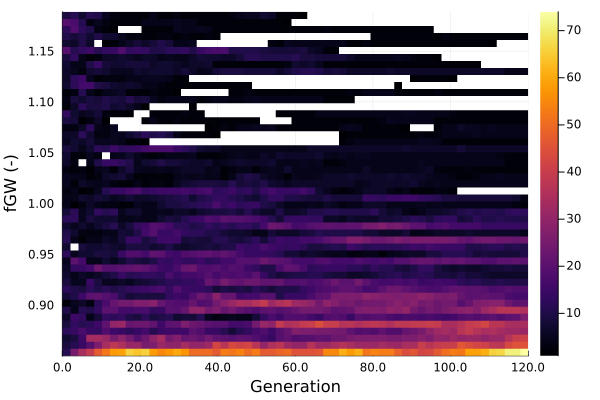

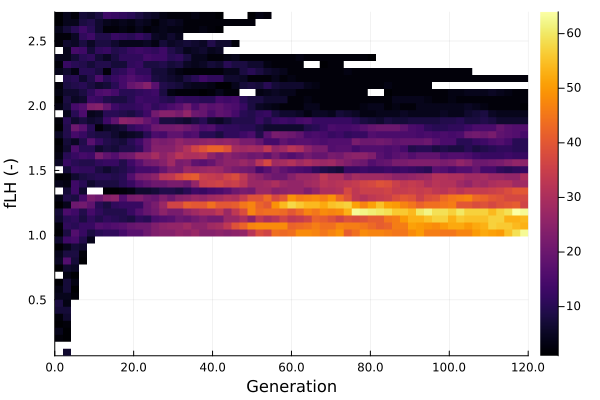

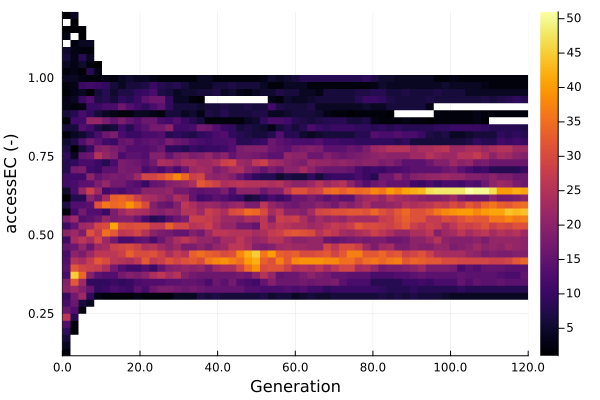

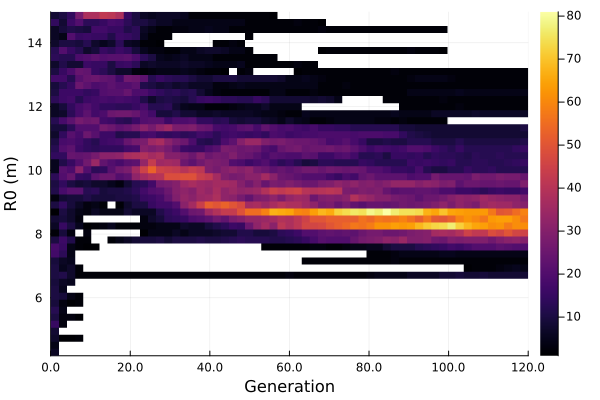

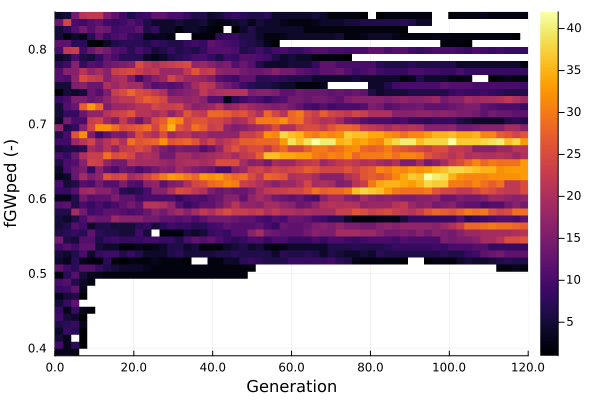

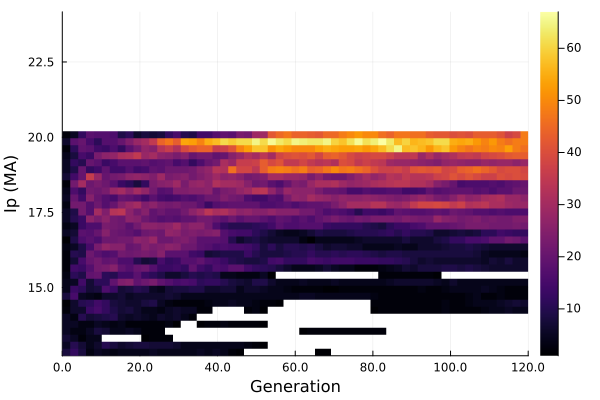

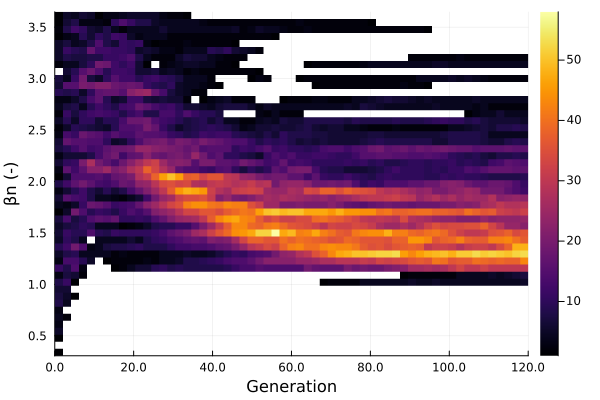

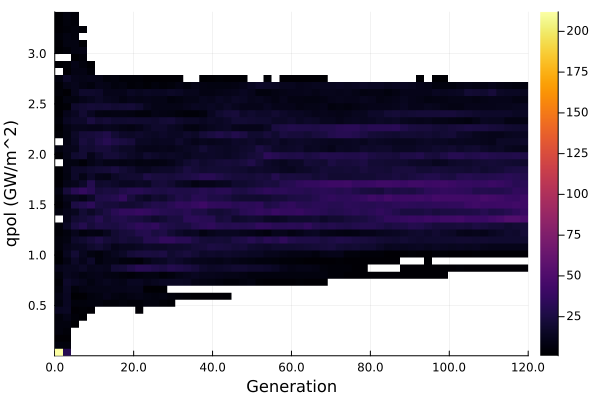

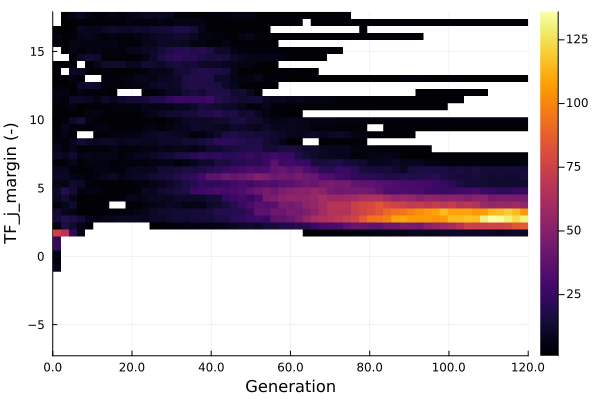

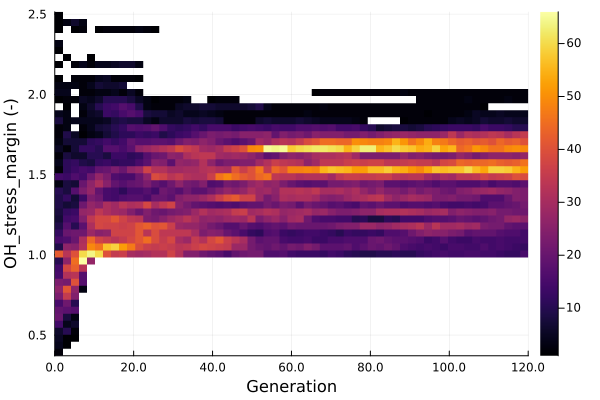

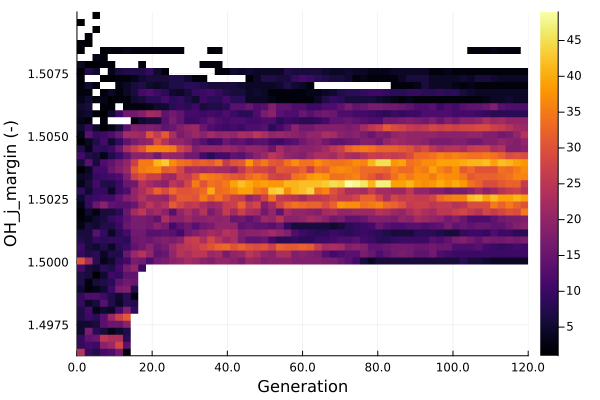

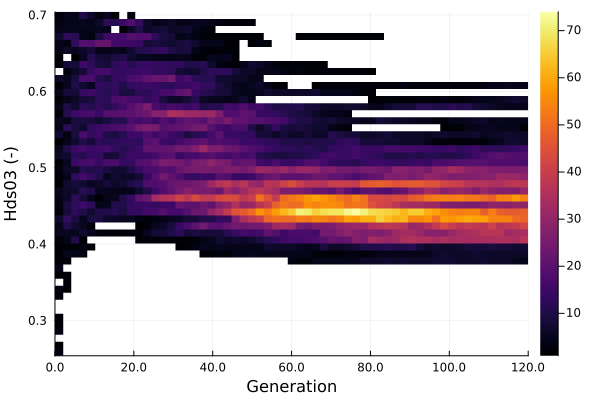

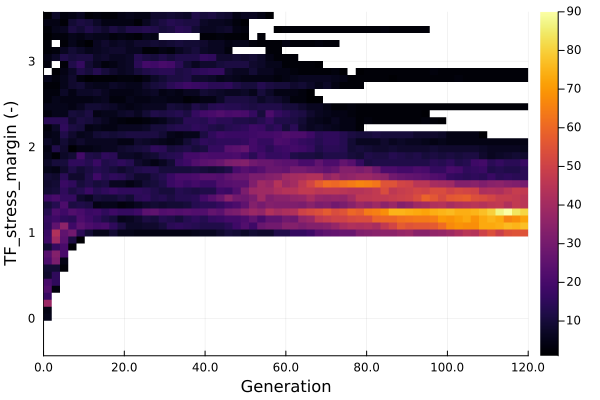

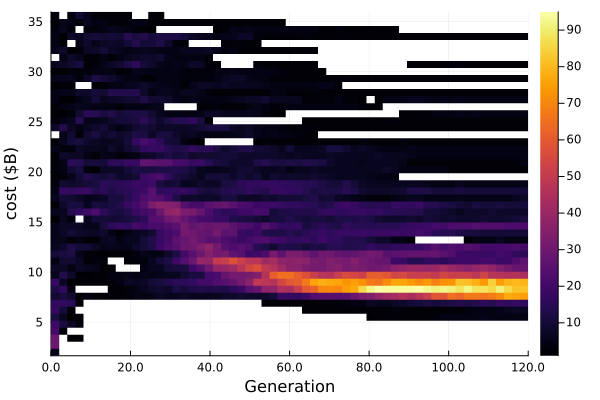

In [8]:
import Statistics
function y_auto_range(y; σ=5, N=50)
    y_nonan = y[@. !isnan.(y)]
    m = Statistics.median(y_nonan)
    s = Statistics.median(Statistics.median(abs.(y_nonan .- m))) * σ
    Y = LinRange(max(m - s, minimum(y_nonan)), min(m + s, maximum(y_nonan)), N)
end

clim = missing
N = 6

for var in keys(db)
    
    y = db[var]
    ngen = size(y)[2]
    X = LinRange(1,length(y),Int(ngen/2))
    yname = var
    
    yflat = vcat(y...)
    Y = y_auto_range(yflat)
    
    p = histogram2d(yflat, bins=(X, Y), ylabel=yname, xlabel="Generation", clim=clim)
    xticks!(LinRange(0,length(y),N+1),[string(x) for x in (LinRange(0,ngen,N+1))])
    display(p)

end



### Define function for scatter plot of ith generation

In [9]:
function scatter_gen(
        con,igen,xlabel,ylabel,
        xrange,yrange,
        fnames,xnames,gnames)
    
    pop = Dict()
    pf = Dict()
    pfi = []

    # assemble function values
    for (i,fname) in enumerate(fnames)
        #str = split(fname, " ")
        str = fname
        pop[str[1]] = [x.f[i] for x in con[igen].population]
        pf[str[1]] = pareto_front(con[igen])[:,i]
    end

    # assemble input values
    for (i,xname) in enumerate(xnames)
        #str = split(xname, " ")
        str = xname
        pop[str[1]] = [x.x[i] for x in con[igen].population]
    for (i,gname) in enumerate(gnames)
        #str = split(gname, " ")
        str = gname
        pop[str[1]] =  [x.g[i] for x in con[igen].population]
    end

    # re-scale constraint values
    @. pop["Pnet"] = min_Pelectric*(1-pop["Pnet"])
    @. pop["fLH"] = min_fLH*(1-pop["fLH"])
    @. pop["accessEC"] = max_accessEC*(1+pop["accessEC"])
    @. pop["Sn"] = max_Sn*(1+pop["Sn"])
    @. pop["qpol"] = max_qpol*(1+pop["qpol"])
    @. pop["ds03"] = max_ds03*(1+pop["ds03"])
    @. pop["TF_j_margin"] = min_TF_j_margin*(1-pop["TF_j_margin"])
    @. pop["OH_j_margin"] = min_OH_j_margin*(1-pop["OH_j_margin"])
    @. pop["TF_stress_margin"] = min_TF_stress_margin*(1-pop["TF_stress_margin"])
    @. pop["OH_stress_margin"] = min_OH_stress_marginpop["OH_stress_margin"]

    # make array of pareto-optimal indices
    for pf in pf[fnames[1]]
        index = findfirst(isequal(pf), pop[fnames[1]])
        pfi = [pfi;[index]]
    end

    # assemble pareto-optimal input values
    for (i,xname) in enumerate(xnames)
        #str = split(xname, " ")
        str = xname
        pf[str[1]] = pop[str[1]][pfi]
    end

    # assemble pareto-optimal constraint values
    for (i,gname) in enumerate(gnames)
        #str = split(gname, " ")
        str = gname
        pf[str[1]] = pop[str[1]][pfi]
    end

    ## PLOT

    s1 = scatter(pop[xlabel], pop[ylabel], color=:grey, label="Population", alpha=0.7)
    s2 = scatter!(s1, pf[xlabel], pf[ylabel], color=:red, label="Pareto-optimal")
    s = plot(s2, size=(450, 450), title="Generation: "*string(igen), xlabel=xlabel, ylabel=ylabel, xrange=xrange, yrange=yrange) 
    
    return s
    
end

scatter_gen (generic function with 1 method)

In [10]:
function scatter_gen2(
        db, pf,
        igen,xlabel,ylabel,
        xrange,yrange)
    
    x = db[xlabel][:,igen]
    y = db[ylabel][:,igen]
    
    xpf = x[pf[igen]]
    ypf = y[pf[igen]]
    
    s1 = scatter(x, y, color=:grey, label="Population", alpha=0.7)
    s2 = scatter!(s1, xpf, ypf, color=:red, label="Pareto-optimal")
    s = plot(s2, size=(450, 450), title="Generation: "*string(igen), xlabel=xlabel, ylabel=ylabel, xrange=xrange, yrange=yrange) 
    
end

scatter_gen2 (generic function with 1 method)

### Make gif of population evolution

[ Info: Saved animation to /fusion/ga/projects/ird/ptp/weisbergd/julia/dev/FUSE/playground/weisberg_FPP_opt/nominal/opt_betaN_cost__Solovev_Kr_flattop24_HTS0.1_qpol2.75_A3.5_Zeff2.0/βn (-)_cost ($B).gif


Plots.AnimatedGif("/fusion/ga/projects/ird/ptp/weisbergd/julia/dev/FUSE/playground/weisberg_FPP_opt/nominal/opt_betaN_cost__Solovev_Kr_flattop24_HTS0.1_qpol2.75_A3.5_Zeff2.0/βn (-)_cost (\$B).gif")
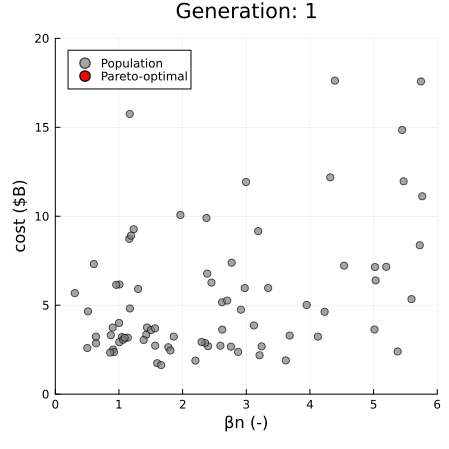

In [15]:
min_Pelectric = 200.0 # MW
min_fLH = 1.0
max_Sn = 1.5
max_qpol = 2.75e3 # MW/m^2
max_ds03 = 1.0
max_accessEC = 1.0
min_TF_j_margin = 1.5
min_OH_j_margin = 1.5
min_TF_stress_margin = 1.0
min_OH_stress_margin = 1.0


xlabel = "βn (-)"
xrange = (0,6)

ylabel = "cost (\$B)"
yrange = (0.0, 20.0)

gen_list = 1:1:length(con)
gen_list = vcat(gen_list,repeat([length(con)],20))

a = @animate for igen in gen_list

    #s = scatter_gen(con,igen,xlabel,ylabel,xrange,yrange,fnames,xnames,gnames)
    s = scatter_gen2(db, pf, igen, xlabel, ylabel, xrange, yrange)
end

g = gif(a, joinpath(result_path, xlabel*"_"*ylabel*".gif"), fps=10)
display(g)

### Static plots

In [12]:
xlabel = "βn (-)"
ylabel = "Hds03 (-)"

xrange = :missing
yrange = :missing

igen = 180

#s = scatter_gen(con,gen_list[end],xlabel,ylabel,xrange,yrange,fnames,xnames,gnames)
s = scatter_gen2(db, pf, igen, xlabel, ylabel, xrange, yrange)


#scatter!(s,outputs[:,"βn_MHD"],outputs[:,"qpol"],markershape=:+,color=:black)



LoadError: BoundsError: attempt to access 256×120 Matrix{Float64} at index [1:256, 180]

In [13]:
size(outputs)

LoadError: UndefVarError: outputs not defined